In [1]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from utils.freq import freq
from utils.bpe import *
import matplotlib.pyplot as plt

## Experiment 1 - Convergence from Zipf?

In [19]:
## does BPE preserve zipfness?

import scipy
n = 5
alphabet_size = 100

## make n truncated-at-alph-size zipf samples
dataset_num = 0
alpha = 1.001
zipf_dist = scipy.stats.zipf(alpha)
data = []

with tqdm(total=10**n) as prog_bar:
    while len(data) < 10**n:
        samp = zipf_dist.rvs(size=1)
        if samp < alphabet_size:
            data.append(samp[0])
            prog_bar.update(1)
        prog_bar.set_description(f'Percent done: {(100*len(data)/10**n):.3f}%')

path = f'data/theory_alph_{alphabet_size}_{n}_{dataset_num}.npy'
as_arr = np.array(data)
print(as_arr.shape)
np.save(path, as_arr)
print(f'Data creation completed and saved at {path}.')

Percent done: 100.000%: 100%|██████████| 100000/100000 [11:34<00:00, 144.09it/s]


(100000,)
Data creation completed and saved at data/theory_alph_100_5_0.npy.


In [32]:
## collect frequency data and collect errors
n = 3
alphabet_size = 100
dataset_num = 0
path = f'data/theory_alph_{alphabet_size}_{n}_{dataset_num}.npy'
arr = np.load(path)

freq_dict = freq(arr=arr)

length_corpus = []

error_data = []
merges = {}
k=800
prog_bar = tqdm(range(k), total=k)
for k_i in prog_bar:
    old_len = len(arr)
    arr, merges, alphabet_size = one_step_of_bpe(
        ids=list(arr),
        merges=merges,
        alphabet_size=alphabet_size
    )
    length_corpus.append(old_len-len(arr))
    freq_dict = freq(arr=arr)

    data = [float(value) for key, value in freq_dict.items()]
    xs = [key_num+1 for key_num, key in enumerate(freq_dict)]
    # calculate zipf mse
    most_common_element = max(freq_dict.values())
    zipf_fit = [most_common_element/x for x in xs]
    # error data
    error = ((np.array(data) - np.array(zipf_fit))**2).mean()
    error_data.append(error)

    prog_bar.set_description(f'Completed {k_i}-th BPE step.')

# save error data
path = f'data/errors_from_zipf_over_bpe_steps.npy'
np.save(path, np.array(error_data))

Completed 799-th BPE step.: 100%|██████████| 800/800 [00:01<00:00, 429.98it/s]


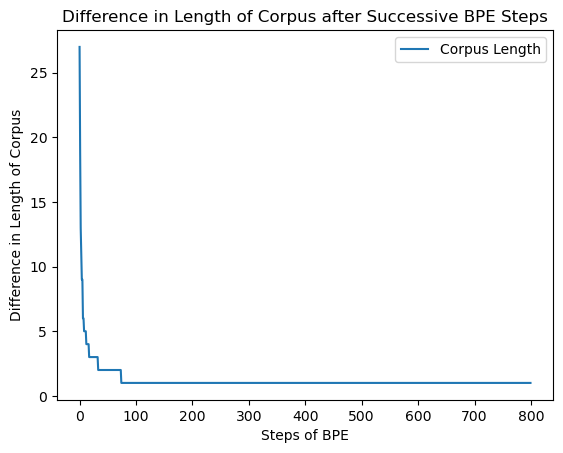

In [34]:
## plot error data
path = f'data/errors_from_zipf_over_bpe_steps.npy'
error_arr = np.load(path)

plt.plot(
    [i for i in range(len(length_corpus))],
    length_corpus,
    label='Corpus Length'
)
plt.title(f'Difference in Length of Corpus after Successive BPE Steps')
plt.xlabel(f'Steps of BPE')
plt.ylabel(f'Difference in Length of Corpus')
plt.legend()
plt.show()

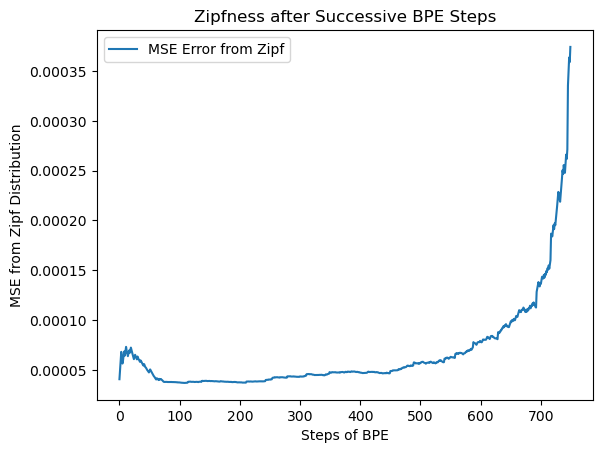

In [27]:
## plot error data
path = f'data/errors_from_zipf_over_bpe_steps.npy'
error_arr = np.load(path)

plt.plot(
    [i for i in range(len(error_arr[:750]))],
    error_arr[:750],
    label='MSE Error from Zipf'
)
plt.title(f'Zipfness after Successive BPE Steps')
plt.xlabel(f'Steps of BPE')
plt.ylabel(f'MSE from Zipf Distribution')
plt.legend()
plt.show()


## Experiment 2 - Convergence from Uniform?

In [2]:
# make uniform data of varying alphabet sizes

def make_data(alph_size: int, n: int, m:int):
    # 10**n elements created
    # m number of repeats of the experiment
    for alphabet_size in [alph_size]:
        for dataset_num in range(m):
            data = np.random.randint(
                low=0,
                high=alphabet_size,
                size=(10**n)
            )
            path = f'data/alph_{alphabet_size}_{n}_{dataset_num}.npy'
            np.save(path, data)

alph_size = 8
n = 6
make_data(alph_size=alph_size, n=n, m=1)

In [ ]:
# byte pair tokenize one at a time

# get settings for analysis
alphabet_size = 25
n = 5
dataset_num = 0
# read in data
path = f'data/alph_{alphabet_size}_{n}_{dataset_num}.npy'
arr = np.load(path)

# analysis
k = 5000 # number of steps of bpe
merges = {}
freq_dict = freq(arr=arr)
freq_dicts = [deepcopy(freq_dict)]

prog_bar = tqdm(range(k), total=k)
for k_i in prog_bar:
    arr, merges, alphabet_size = one_step_of_bpe(
        ids=arr, 
        merges=merges, 
        alphabet_size=alphabet_size
    )
    freq_dict = freq(arr=arr)
    freq_dicts.append(freq_dict)
    prog_bar.set_description(f'Completed {k_i}-th BPE step.')


(100000,)


Completed 13-th BPE step.:   0%|          | 14/5000 [00:01<11:33,  7.19it/s]


KeyboardInterrupt: 

In [4]:
# make zipf and error data

# zipf's law
xs_data = []
loglog_data = []
zipfs_data = []
error_data = []
for freq_dict in freq_dicts:
    # format data
    xs = [key_num+1 for key_num, key in enumerate(freq_dict)]
    xs_data.append(xs)
    data = [float(value) for key, value in freq_dict.items()]
    loglog_data.append(data)
    # zipf data
    most_common_element = max(freq_dict.values())
    zipf = [most_common_element/x for x in xs]
    zipfs_data.append(zipf)
    # error data
    error = ((np.array(data) - np.array(zipf))**2).mean()
    error_data.append(error)



Saved animation at: ./visualizations/alph_100.gif


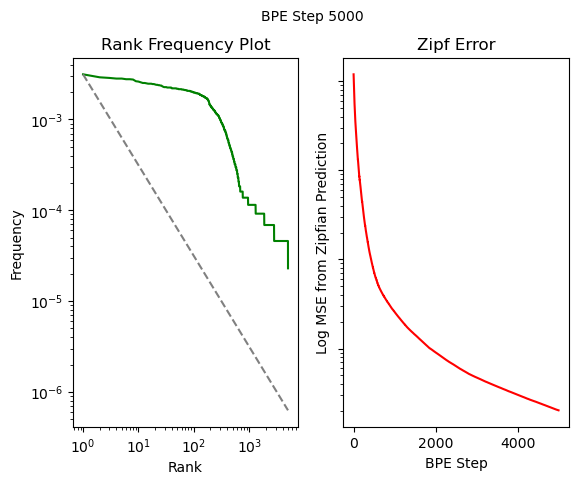

In [5]:
# animate
from utils.anim import anim

alphabet_size = 100
anim(
    xs_data=xs_data,
    loglog_data=loglog_data,
    zipfs_data=zipfs_data,
    error_data=error_data,
    save_path=f'./visualizations/alph_{alphabet_size}.gif',
)
